# <center> Прогнозирование вероятности оттока пользователей для фитнес-центров 
<center> Автор материала: Толстошеева Татьяна (@tsheeva)

## Описание
Чтобы бороться с оттоком клиентов, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов, а именно:
- срогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

## Ознакомление с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import itertools


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
# прочитаем из csv-файла данные и сохраним их в переменной:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#посмотрим на сводную информацию о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#распечатаем его размер и первые 5 строк
print(data.shape)
display(data.head())

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Набор данных включает следующие поля:

 Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.


- 'Churn' — факт оттока в текущем месяце.

In [5]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [6]:
#проверим на дубликаты
data.duplicated().sum()

0

### Вывод

Мы прочитали данные и изучили их размер, сводную информацию, проверили на пропуски и дубликаты. Для удобства дальнейшей работы привели названия столбцов к нижнему регистру. Данные готовы к EDA. 

## Исследовательский анализ данных (EDA)

### Средние значения и стандартные отклонения

In [7]:
# изучим средние значения и стандартные отклонения:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Данные распределены равномерно, аномалий не наблюдается. 

В выборке представлены почти в равной доле мужчины и женщины в возрасте от 18 до 41 года. 85% из них работают или живут рядом с фитнес-центром, а почти половина - являются сотрудником компании-партнера клуба. Больше половины посетителей берут абонемент на 1 месяц.

In [8]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:
data.groupby('churn').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Клиенты, которые уходят в отток, моложе, живут или работают от фитнес центров дальше, реже работают в компаниях-партнерах центра, реже приходят по акции "приведи друга", реже ходят на тренировки, в том числе и на групповые занятия. Они значительно меньше траят на дополнительные услуги. 

### Диаграммы оттока

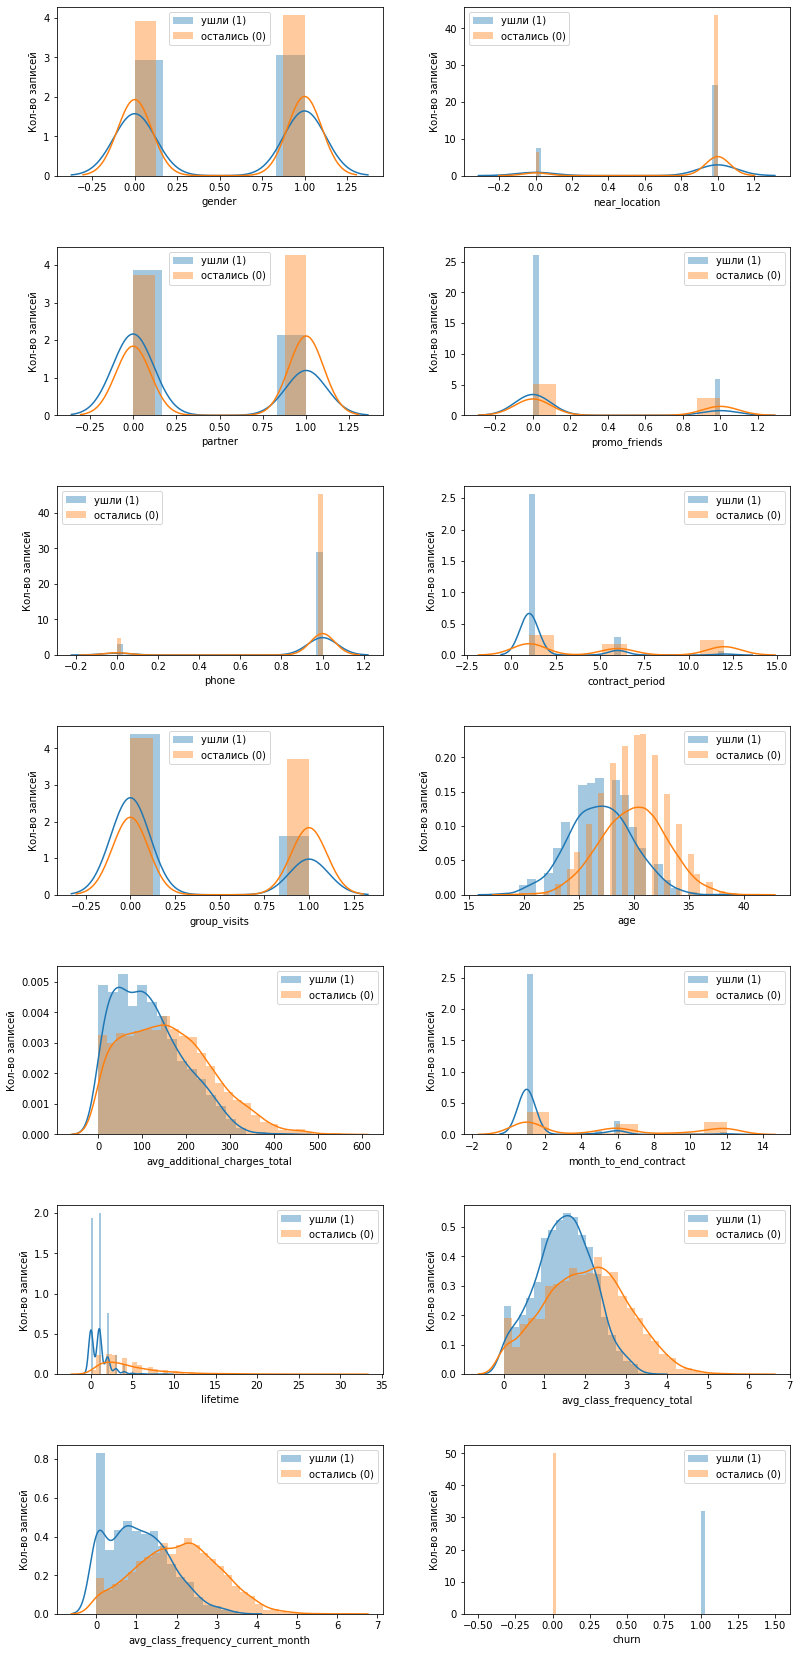

In [9]:
# построим столбчатые гистограммы для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12,24)) # чертим сетку
axes_list = [item for sublist in axes for item in sublist] # создаем список 
fig.tight_layout(pad=5.0) # корректируем размер подграфиков
for feature in data.columns:
    ax = axes_list.pop(0)
    sns.distplot(data.query('churn == 1')[feature], ax=ax, kde=True, label='ушли (1)')
    sns.distplot(data.query('churn == 0')[feature], ax=ax, kde=True, label='остались (0)')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Кол-во записей', fontsize=10)
    ax.legend()

На диаграммах мы видим:
- мужчины и женщины почти в равных долях посещают фитнес-центр, и почти одинаково попадают в отток;
- живущих/работающих рядом клиентов намного больше, среди них значительно больше людей остаются лояльными;
- клиенты, пришедшие по партнерской программе, реже попадают в отток;
- клиенты, пришедшие по акции "приведи друга", чаще остаются лояльными;
- не оставившие свой номер телефона клиенты - скорее исключение из правил;
- абонементы чаще всего приобретают на 1 месяц, затем на 12 и на 6. В отток в основном уходят клиенты, которые взяли абонемент на 1 месяц. Много таких клиентов и в шестимесячных абонементах;
- большая часть людей, которые ходит на групповые занятия - лояльны и в отток не попадают;
- на графике хорошо видно, как смещено распределение по возрасту ушедших и лояльных клиентов: чем старше - тем больше вероятность остаться, и наоборот.
- и ушедшие и лояльные клиенты совершали траты, правда первые тратили часто и по чуть-чуть, вторые тратились реже, но значительно больше
- график Month_to_end_contract сильно коррелирует с Contract_period;
- чем дольше лайфтайм, тем меньше отток. Чаще всего люди отваливаются в первые 2 месяца. Многие, кстати отваливаются, так и не начав ходить;
- в среднем, ушедшие посещали 1-2 занятия в неделю за все время, в то время как лояльные клиенты в среднем посещали 1-3 занятия в неделю
- за месяц до оттока клиенты часто вообще не посещали центр. Тут, как и в предыдущем пункте видно, что чем чаще клиент посещает занятия, тем меньше отток.

### Распределение признаков

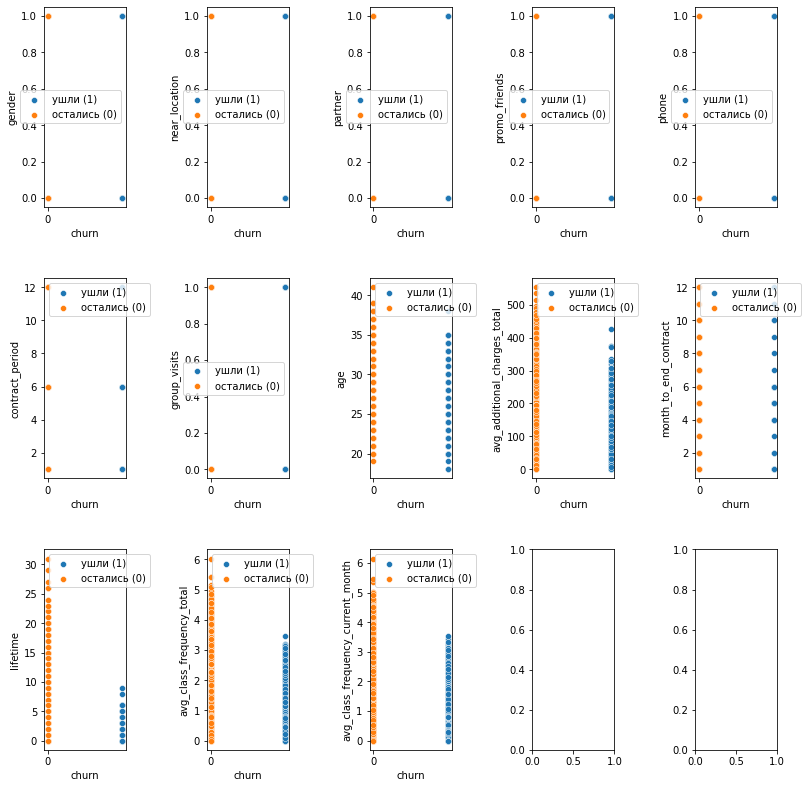

In [10]:
# построим распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12,12)) # чертим сетку
axes_list = [item for sublist in axes for item in sublist] # создаем список 
fig.tight_layout(pad=5.0) # корректируем размер подграфиков
for feature in data.drop('churn', axis = 1).columns:
    ax = axes_list.pop(0)
    sns.scatterplot(x=data.query('churn == 1')['churn'], y=data[feature], ax=ax, label='ушли (1)') 
    sns.scatterplot(x=data.query('churn == 0')['churn'], y=data[feature], ax=ax, label='остались (0)')
    ax.set_xticks(range(0,1))

ax.legend()

Мы видим, что:
- Возраст ушедших в отток редко превышает 35 лет, что тратят они в среднем не более 300 у.е., берут абонементы на 12 месяцев, но ходят не больше 10, в среднем ходят в центр не более 3-4 раз.
- Возраст не попавших в отток клиентов доходит до 40 лет, разброс в средних значениях дополнительных трат больше, превышает 500 у.е., лайфтайм не ограничивается самым длинным абонементом, а максимально доходит до 31 месяца. В это число входят настоящие спортсмены, которые в среднем посещают клуб до 6 раз в неделю!

### Матрица корреляций

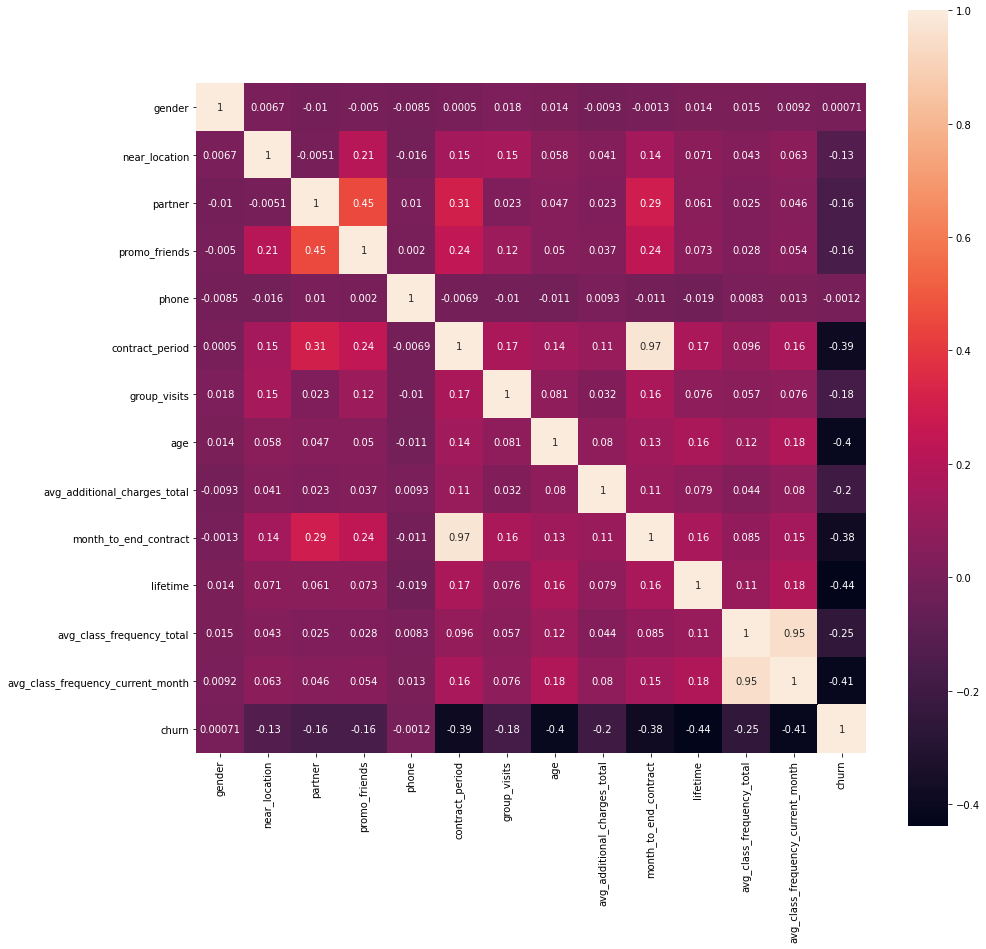

In [11]:
# построим матрицу корреляций
cm = data.corr() #вычисляем матрицу корреляций
plt.figure(figsize=(15,15))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True) 

plt.show()

- сильно коррелируют между собой величина абонемента и количество месяцев до его окончания. Как мы уже увидели на диаграммах выше, подавляющее число клиентов покупают абонементы на месяц, не удивительно, что они всегда находятся в зоне "месяц до окончания абонемента";
- сильно связаны параметры 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month';
- также связаны признаки 'Partner' и 'Promo_friends'. Напомню, что это программы, по которым можно получить скидки на приобретение абонемента. Интересно, а скидки между собой суммируются?
- пол и наличие контактного телефона не коррелируют ни с одним параметром.

Отрицательная корреляция у целевого параметра 'churn':
- зависит от лайфтайма;
- от возраста клиента;
- от длительности абонемента и времени его окончания;
- от среднего количества посещений в неделю за предыдущий месяц (с 'Avg_class_frequency_total' также коррелирует, но в меньшей степени)

### Вывод

Мы проверили данные на пропуски, изучили средние значения и стандартные отклонения, средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Построили матрицу корреляций, столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток). 

В выбоке представлены почти в равной доле мужчины и жещины в возрасте от 18 до 41 года. Больше 75% из них работают или живут рядом с фитнес-центром, половина - являются сотрудником компании-партнера клуба. Больше половины посетителей берут абонемент на 1 месяц.

На основании EDA, мы уже можем предположить, что и как влияет на целевую переменную. Чем ниже следующие показатели, тем больше вероятность оттока клиентов в текущем месяце:
- длительность абонемента;
- возраст;
- среднее количество посещений за последний месяц;
- участие в акциях;
- лайфтайм.

Также необходимо обратить внимание на признаки, которые сильно коррелируют между собой - аvg_class_frequency_total'/'аvg_class_frequency_current_month и 'contract_period'/'month_to_end_contract'. Модель линейной регрессии склонна неустойчива в случае взаимной корреляции признаков.

## Прогнозирование оттока клиентов

In [12]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [13]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis = 1)
y = data['churn']

# разделим  модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train) # обучаем scaler на обучающей выборке методом fit

X_train_st = scaler.transform(X_train) # стандартизируем обучающую выборку методом transform scaler
X_test_st = scaler.transform(X_test)# стандартизируем тестовую выборку методом transform scaler

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь

In [14]:
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


### Вывод
Мы построили модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для этого мы разбили данные на обучающую и валидационную выборку и обучили модель на train-выборке двумя способами (логистической регрессией и случайным лесом).

По метрикам accuracy, precision и recall видно, что модели логистической регрессии немного лучше случайного леса, но в обоих случаях показатели высокие, можно использовать обе модели.

## Кластеризация клиентов

In [15]:
# Отложим в сторону столбец с оттоком и два сильно коррелирующих признака, стандартизируем данные:
sc = StandardScaler()
X_sc = sc.fit_transform(data.drop(['churn', 'avg_class_frequency_total', 'month_to_end_contract'], axis=1))

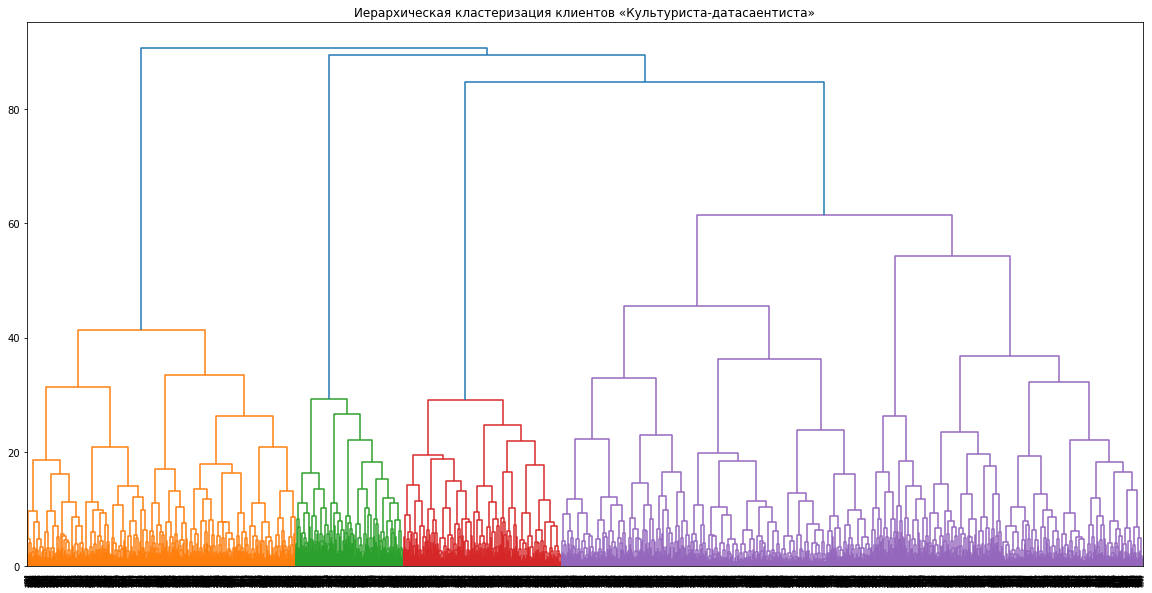

In [16]:
# построим матрицу расстояний функцией linkage():
linked = linkage(X_sc, method = 'ward')

# нарисуем дендрограмму
plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов «Культуриста-датасаентиста»')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике. Но один из них можно поделить еще на 2. Остановимся на пяти. 

### Среднее значение по каждому кластеру

In [17]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels
 
# выводим статистику по средним значениям наших признаков по кластеру и отсортируем по среднему показателю оттока
cluster_data = data.groupby('cluster_km').mean()
display(cluster_data.T)

cluster_km,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
month_to_end_contract,6.332995,2.818996,1.941729,5.650447,4.466321


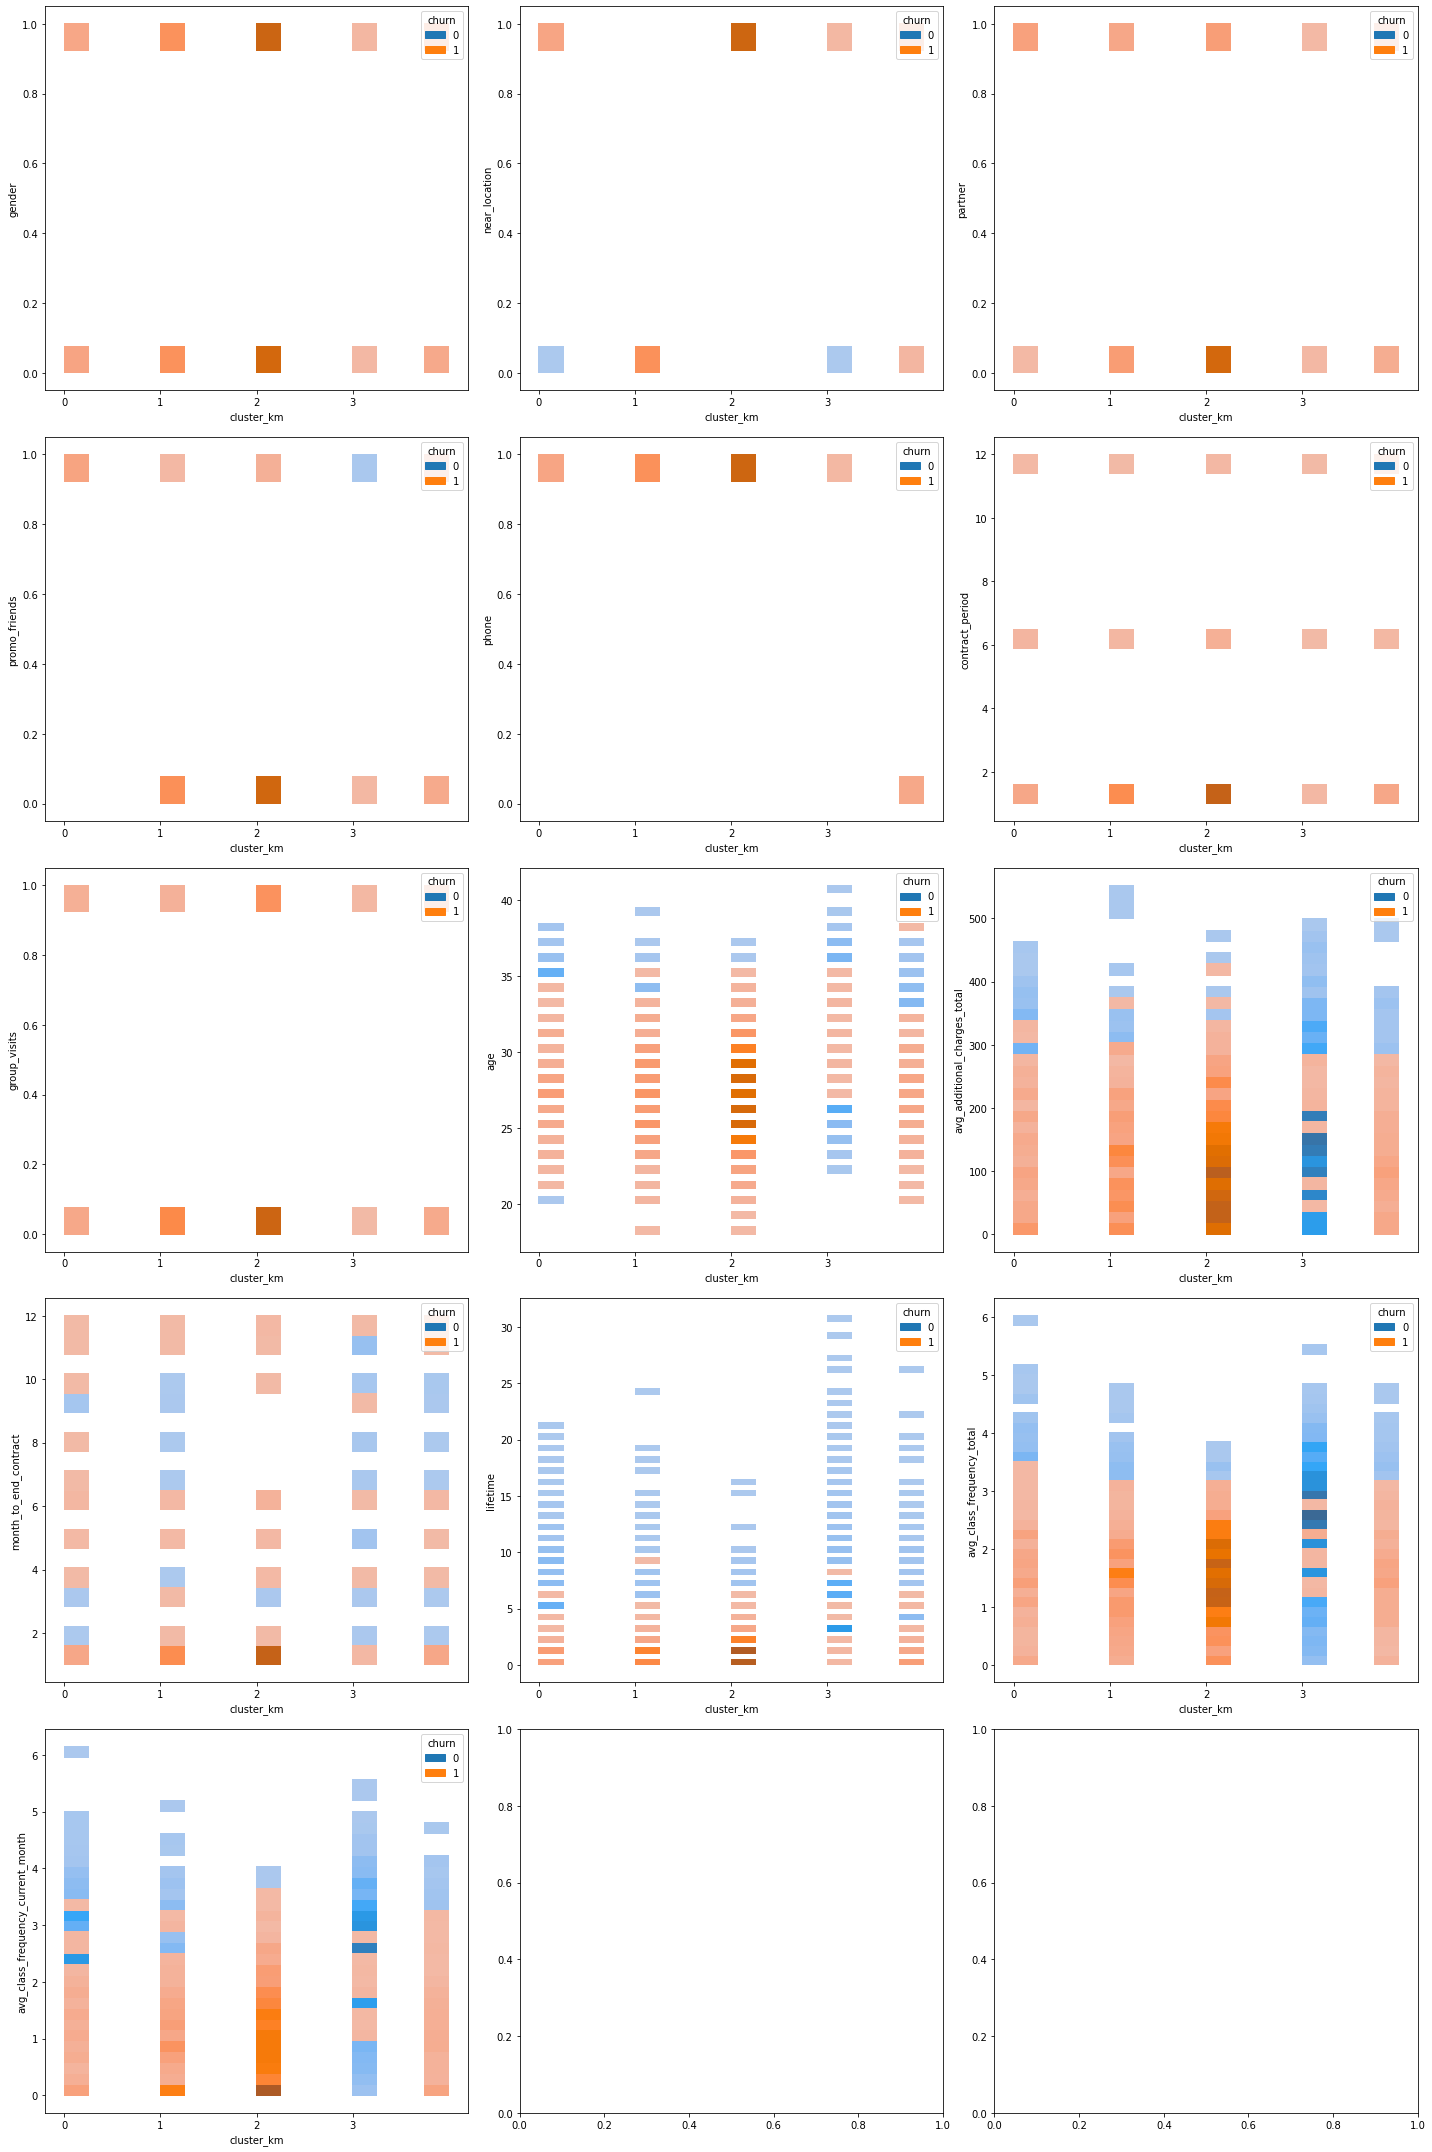

In [19]:
# построим распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,30)) # чертим сетку
axes_list = [item for sublist in axes for item in sublist] # создаем список 
fig.tight_layout(pad=5.0) # корректируем размер подграфиков
for feature in data.drop(['cluster_km', 'churn'], axis = 1).columns:
    ax = axes_list.pop(0)
    sns.histplot(data, x='cluster_km', y=feature, hue='churn', ax=ax)
    ax.set_xticks(range(0,4))
fig.tight_layout()

На диаграммах и по средним значениям признаков по кластерам мы видим как произошло разделение клиентов:
- в 0 кластер попали только те клиенты, которые пришли по акции "приведи друга";
- в 1 кластер попали только те, кто живет или работает далеко от фитнес центра;
- во 2 кластер попали только те, кто живет или работает близко к фитнес центру;
- в 3 кластере в основом клиенты, которые не учавствовали в акции "приведи друга";
- в 4 попали те, кто не оставил контактный номер телефона.

### Доля оттока для каждого кластера

In [20]:
# рассчитаем долю оттока для каждого кластера: 
cluster_data['churn_part'] = data.query('churn==1').groupby('cluster_km')['churn'].count() / data.query('churn==1')['churn'].count()
cluster_data.reset_index() 

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,churn_part
0,0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,6.332995,4.283249,1.962217,1.919520,0.119797,0.111216
1,1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.818996,2.974910,1.764122,1.597146,0.403226,0.212064
2,2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.941729,1.922932,1.451098,1.203319,0.563910,0.565504
3,3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.650447,5.415094,2.322960,2.324220,0.014896,0.014138
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839,0.097078


2 кластер - самый склонный к оттоку, его доля составляет 56,6%. Несмотря на то, что все они живут/работают рядом с клубом, лайфтайм там самый низкий. 
3 кластер - самый надежный, доля оттока всего 1,41%. Это самая возрастная группа с самым большим лайфтаймом. 

### Вывод

Мы стандартизировали данные, построили дендрограмму и выделили 5  кластеров. Спрогнозировав кластеры клиентов, посмотрели на срадние значения признаков, построили распределения и посчитали доли оттока. Вот что мы выяснили: 

- в 0 кластер попали только те клиенты, которые пришли по акции "приведи друга", доля оттока 11,1%;
- в 1 кластер попали только те, кто живет или работает далеко от фитнес центра, доля оттока 21,2%;
- во 2 кластер попали только те, кто живет или работает близко к фитнес центру, доля оттока 56,6%;
- в 3 кластере в основом клиенты, которые не учавствовали в акции "приведи друга", доля оттока 1,41%;
- в 4 попали те, кто не оставил контактный номер телефона, доля оттока 9,71%.

Получается, что на отток не влияет расположение к центру (1 и 2 кластеры с самой высокой долей оттока как раз сформированы на этом признаке), акция "приведи друга" тоже не влияет на отток. Влияет возраст, лайфтайм и среднее количество посещений в неделю. 

## Общие выводы и рекомендации

Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами
Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания. 
Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

Мы прочитали данные и изучили их размер, сводную информацию, проверили на пропуски и дубликаты, привели названия столбцов к нижнему регистру. 

Далее мы провели сследовательский анализ данных(EDA):

- изучили средние значения и стандартные отклонения;

- посмотрели на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;

- построили столбчатые гистограммы и распределения признаков

- создали построим матрицу корреляций и отобразили ее на тепловой карте.

В результате EDA мы смогли создать предположительный портрет лояльных клиентов, и клиентов, ушедших в отток. Так, последние моложе, живут или работают от фитнес-центров дальше, реже работают в компаниях-партнерах центра, реже приходят по акции "приведи друга", реже ходят на тренировки, в том числе и на групповые занятия. Они значительно меньше тратят на дополнительные услуги.

Мы также обнаружили признаки, которые сильно коррелируют между собой - 'аvg_class_frequency_total'/'аvg_class_frequency_current_month' и 'contract_period'/'month_to_end_contract'. Мы учли это в дальнейшем исследовании. 

Следом мы построили модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце, разбили данные на обучающую и валидационную выборку и обучили модель на train-выборке двумя способами (логистическая регрессия и случайный лес). Мы сравнили результаты и выяснили, что метрики модели логистической регрессии немного выше метрик случайного леса, но в обоих случаях показатели высокие, можно использовать обе модели.

Мы стандартизировали данные, построили дендрограмму и выделили 5  кластеров. Спрогнозировав кластеры клиентов, посмотрели на срадние значения признаков, построили распределения и посчитали доли оттока. Вот что мы выяснили: 

- в 0 кластер попали только те клиенты, которые пришли по акции "приведи друга", доля оттока 11,1%;
- в 1 кластер попали только те, кто живет или работает далеко от фитнес центра, доля оттока 21,2%;
- во 2 кластер попали только те, кто живет или работает близко к фитнес центру, доля оттока 56,6%;
- в 3 кластере в основом клиенты, которые не учавствовали в акции "приведи друга", доля оттока 1,41%;
- в 4 попали те, кто не оставил контактный номер телефона, доля оттока 9,71%.

Получается, что на отток не влияет расположение к центру (1 и 2 кластеры с самой высокой долей оттока как раз сформированы на этом признаке), акция "приведи друга" тоже не влияет на отток. Влияет возраст, лайфтайм и среднее количество посещений в неделю. 



### Рекомендации


- Продолжать увеличивать количество новых клиентов предлагая партнерские программы и промо-акции;
- Работать над тем, чтобы новые клиенты брали абонементы не на 1 месяц, а на более длительное время. Если 6 месяцев - слишком большой срок для тех, кто только начинает заниматься, то абонементы на 3 месяца - возможность удержать клиентов на более длительный срок.
- Очень много тех, кто покупает абонемент, но не приходит ни на одно занятие. Работать с этими клиентами. 
- Продумать разные стратегии удержания для разных возрастов.